In [52]:
import os
from pymongo import MongoClient
import pandas as pd
from dotenv import load_dotenv

# Load environment variables
load_dotenv("../.env")  
client = MongoClient(os.getenv("MONGODB_CONNECTION_STRING"))
db = client["cricket_elo"]
player_ratings_collection = db["player_ratings"]

def get_top_n_players(n=10):
    """Fetches the top N players based on their latest Elo rating."""
    players = list(player_ratings_collection.find({}, {"_id": 0, "player_name": 1, "ratings": 1}))

    latest_ratings = []
    for player in players:
        
        if player["ratings"]:
            latest_entry = player["ratings"][-1]  # Get latest match rating
            latest_ratings.append({
                "player_name": player["player_name"],
                "batting_rating": latest_entry["batting_rating"],
                "bowling_rating": latest_entry["bowling_rating"],
                "n_entries": len(player["ratings"])
            })
        if player['player_name'] == 'V Kohli':
            print(latest_entry)
        

    # Convert to DataFrame for sorting
    df = pd.DataFrame(latest_ratings)
    
    # Get Top N Batters & Bowlers
    top_batters = df.loc[(df['batting_rating']!=1000) & (df['n_entries']>50)].nlargest(n, "batting_rating")[["player_name", "batting_rating"]].reset_index(drop=True)
    top_bowlers = df.loc[(df['bowling_rating']!=1000) & (df['n_entries']>50)].nlargest(n, "bowling_rating")[["player_name", "bowling_rating"]].reset_index(drop=True)

    top_batters.index += 1
    top_bowlers.index += 1

    return top_batters, top_bowlers, df

# Fetch and display top players
n = 20
top_batters, top_bowlers, df = get_top_n_players(n)
print(f" Top {n} Batters:\n", top_batters)
print(f"\n Top {n} Bowlers:\n", top_bowlers)

{'date': '2024-05-04', 'batting_rating': 1307.1054873760768, 'bowling_rating': 1000}
 Top 20 Batters:
       player_name  batting_rating
1       JJ Bumrah     1416.187362
2        HV Patel     1377.663450
3       SP Narine     1376.226730
4        MS Dhoni     1371.810091
5        SA Yadav     1371.361268
6      AD Russell     1371.171067
7        AR Patel     1360.007449
8       SV Samson     1353.821190
9        R Ashwin     1353.080712
10         S Dube     1352.049085
11       TA Boult     1350.628381
12   F du Plessis     1349.915202
13      RA Jadeja     1348.080765
14     KD Karthik     1348.048151
15      DA Miller     1343.811699
16      R Tewatia     1343.427880
17  Kuldeep Yadav     1342.798760
18      KH Pandya     1340.702150
19       N Pooran     1335.241375
20        R Parag     1334.491084

 Top 20 Bowlers:
        player_name  bowling_rating
1        JJ Bumrah     1416.187362
2         CV Varun     1399.965244
3        RD Chahar     1377.362008
4        SP Narine     1

In [49]:
df.sort_values(by='batting_rating', ascending=False).loc[df['player_name'] == 'V Kohli']

,player_name,batting_rating,bowling_rating,n_entries
109,V Kohli,1274.799674,1000.0,103


<Axes: ylabel='Frequency'>

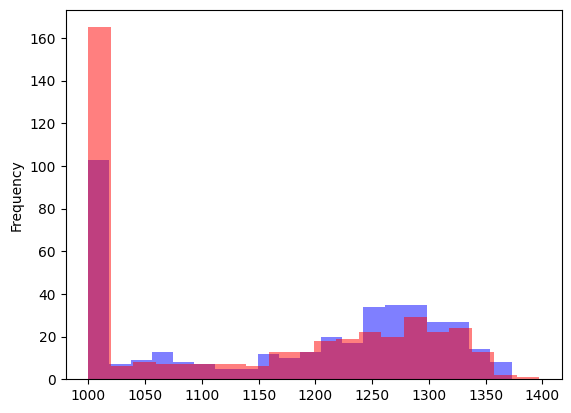

In [41]:
df['batting_rating'].plot.hist(bins=20, alpha=0.5, color='blue', label='Batting Ratings')
df['bowling_rating'].plot.hist(bins=20, alpha=0.5, color='red', label='Bowling Ratings')

<Axes: title={'center': 'Virat Kohli Batting Ratings'}, xlabel='Date', ylabel='Rating'>

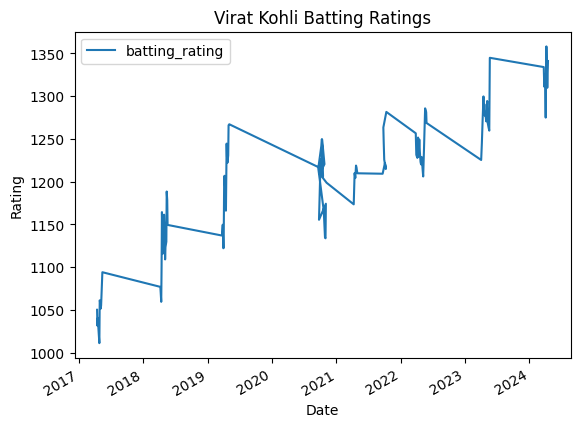

In [50]:
virat_kohli = player_ratings_collection.find_one({"player_name": "V Kohli"}, {"_id": 0, "player_name": 1, "ratings": 1})
df_kohli = pd.DataFrame(virat_kohli["ratings"])
df_kohli["date"] = pd.to_datetime(df_kohli["date"])
df_kohli.plot(y='batting_rating', x='date', title='Virat Kohli Batting Ratings', xlabel='Date', ylabel='Rating')

In [45]:
df_kohli.head()

,date,batting_rating,bowling_rating
0,2017-04-14,1050.021699,1000
1,2017-04-16,1031.417645,1000
2,2017-04-18,1040.297703,1000
3,2017-04-23,1023.492588,1000
4,2017-04-27,1011.020755,1000


<Axes: >

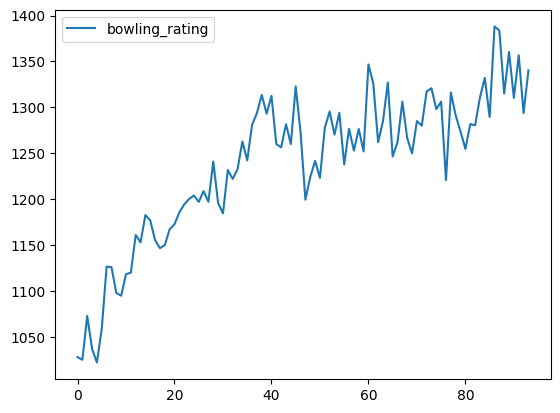

In [43]:
bumrah = player_ratings_collection.find_one({"player_name": "JJ Bumrah"}, {"_id": 0, "player_name": 1, "ratings": 1})
df_bumrah = pd.DataFrame(bumrah["ratings"])
df_bumrah["date"] = pd.to_datetime(df_bumrah["date"])
df_bumrah.plot(y='bowling_rating')

MovieWriter ffmpeg unavailable; using Pillow instead.
C:\Users\sprua\AppData\Local\Temp\ipykernel_12884\2669149415.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


ValueError: unknown file extension: .mp4

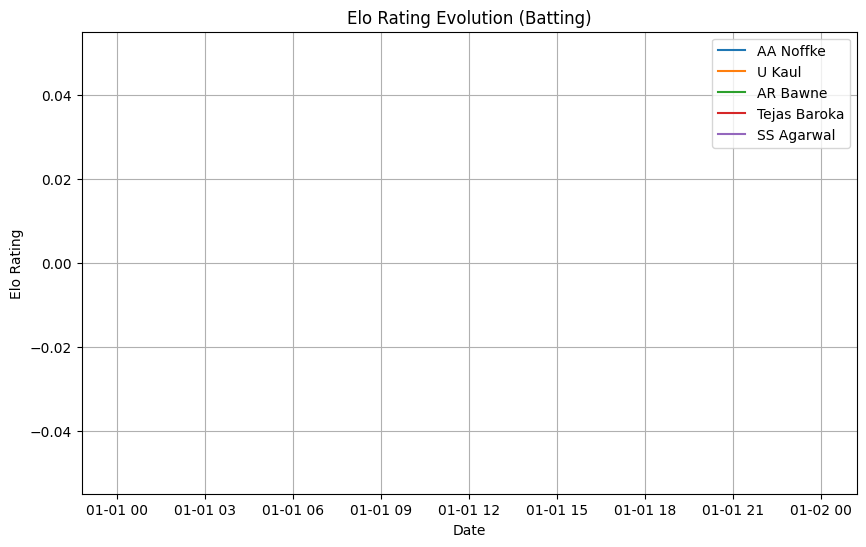

In [2]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

def get_player_rating_history(player_name):
    """Fetch a player's entire rating history."""
    player = player_ratings_collection.find_one({"player_name": player_name}, {"_id": 0, "ratings": 1})
    if not player:
        return None
    df = pd.DataFrame(player["ratings"])
    df["date"] = pd.to_datetime(df["date"])  # Convert to datetime
    return df.sort_values("date")

def create_rating_animation(top_n_players, rating_type="batting", output_file="rating_evolution.mp4"):
    """Creates an animated time series plot for top N players."""
    fig, ax = plt.subplots(figsize=(10, 6))

    # Extract rating history for top N players
    histories = {p: get_player_rating_history(p) for p in top_n_players}

    def update(frame):
        ax.clear()
        ax.set_title(f"Elo Rating Evolution ({rating_type.title()})")
        ax.set_xlabel("Date")
        ax.set_ylabel("Elo Rating")
        ax.grid(True)

        for player, history in histories.items():
            if history is not None and frame < len(history):
                ax.plot(history["date"][:frame], history[f"{rating_type}_rating"][:frame], label=player)

        ax.legend()

    ani = animation.FuncAnimation(fig, update, frames=100, interval=100)
    ani.save(output_file, writer="ffmpeg")
    plt.close()

# Get top players
top_batters, _ = get_top_n_players(5)

# Create animation for top 5 batters
create_rating_animation(top_batters["player_name"].tolist(), "batting", "batting_rating_evolution.mp4")

print("🎥 Batting rating evolution video saved!")
